In [1]:
%load_ext cython
%matplotlib inline
import sys
sys.path.append('/home/bram/ANTS')
sys.path.append('/home/bram/ANTS/entropy')
for p in sys.path:
    print(p)


/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages/IPython/extensions
/home/bram/.ipython
/home/bram/ANTS
/home/bram/ANTS/entropy


--init--
[0. 0.]
Max of map == 0.0039840478723192334, sum == 1000.0000000004193
Max of map == 0.04832126369558666, sum == 999.999999999961
step took 0.5729379653930664 msec






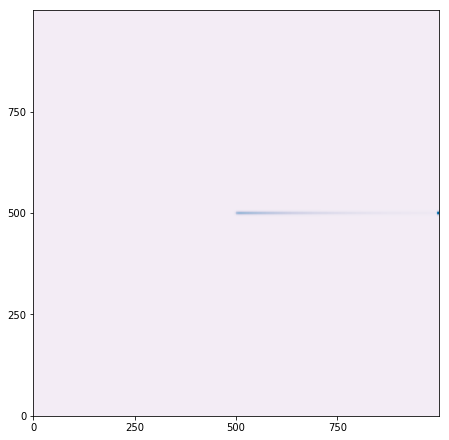

Evaporate took 0.8899688720703125 msec
C-Evaporate took 4.539597034454346 msec 
999.9999999997699
C is 0.19604578673298162 times faster
C-max took 0.6620883941650391 msec 
Py-max took 0.37178993225097656 msec 
C-max is 0.5615412315448326 times faster
--done--
6
[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[500.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [2]:
%%cython
from cythonic.core.queen cimport queen
from cythonic.core.domain cimport domain
from cythonic.core.ant cimport Ant as ant
from cythonic.plugins.positions cimport point, ant_state
from cythonic.plugins.rng cimport RNG
from cythonic.plugins.functions cimport deg
from cython.parallel cimport prange
from entropy.core.visualization import StigmergyPlot, Plotter
from libc.math cimport M_PI, cos as ccos, sin as csin
import numpy as np
cimport numpy as cnp
cimport cython

cdef double pitch = 2
cdef double[2] limits = np.array([1000,1000],dtype=np.float_)
cdef double[2] size = limits, nest = np.array([25.,50.]), food = np.array([75.,50.])
cdef double R=5.
# cdef struct ant_state:
#     double x
#     double y
#     double theta

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
cdef class sim_controller():
    cdef domain dom
    cdef queen controller
    cdef ant solo
    cdef double[:] Q_map #pheromone volume under left and right antenna:  [Qleft, Qright]
    cdef double[:,::1] ant_xy_theta
    cdef double[::1] ant_q
    cdef double Q_deposit, t #deposit pheromone volume
    cdef unsigned int n_agents, deployed
    cdef str sens_fun, deploy_location
    cdef double[:] deploy_time
    cdef unsigned int i
    cdef RNG rng
    
    def __cinit__(self, dom_dict, ant_dict,sim_dict):
        print('--init--')
        self.dom = domain(**dom_dict)
        self.solo = ant(id =1, **ant_dict)
        self.Q_map = np.zeros([2],dtype= np.float_)
        self.Q_deposit = 1e3
        self.start_sim(**sim_dict)
        self.i=0
        self.rng = RNG()
        self.deployed = 0
        
    cdef void make_deploy_time(self,str method):
        if method == 'instant':
            self.deploy_time = np.zeros(self.n_agents,dtype=np.float_)
        
    cpdef cnp.ndarray[ndim = 1,dtype=cnp.npy_float64] get_pos(self):
        return np.array([self.solo._pos.x,self.solo._pos.y],dtype = np.float_)
    
    cdef void evaporate(self):
        self.dom.pyvaporate()
            
    cdef void cevaporate(self):
        self.dom.cvaporate()
        
    @property
    def xs(self):
        return np.array(self.ant_xy_theta[:,0])
    @property
    def ys(self):
        return np.array(self.ant_xy_theta[:,1])
    @property
    def thetas(self):
        return np.array(self.ant_xy_theta[:,2])
        
    cdef void store(self,unsigned int* i, point* p, double* theta):
        " store position and orientation of all ants in a long np.ndarray "
        self.ant_xy_theta[i[0],0] = p[0].x
        self.ant_xy_theta[i[0],1] = p[0].y
        self.ant_xy_theta[i[0],2] =  theta[0]
        
    cdef ant_state deploy_pos(self, unsigned int *n):
        cdef ant_state x
        if self.deploy_location =='nest':
            x.theta = self.rng.rand()*M_PI*2
            x.x  =self.dom.nest_location.x + ccos(x.theta)*self.dom.nest_radius
            x.y  =self.dom.nest_location.y+csin(x.theta)*self.dom.nest_radius
            x.theta=deg(&x.theta)
        return x
            
        
    cdef void gradient_step(self,double dt):
        cdef unsigned int i, n, N = 80
        for i in range(N):
            self.Q_map[0] = self.dom.probe_pheromone(&self.solo._left)
            self.Q_map[1] = self.dom.probe_pheromone(&self.solo._right)
            self.ant_q[0] = self.solo.return_drop_quantity(&dt) #store deposited pheromone in array for all ants
            self.store(&self.i, &self.solo._pos, &self.solo._azimuth)
            self.dom.add_pheromone(p=&self.solo._pos,Q= &self.ant_q[0])
            self.solo.gradient_step(dt,self.sens_fun,self.Q_map)
        self.cevaporate()
        if self.deployed < self.n_agents:
            "deploy more agents"
            n = np.sum(np.array(self.deploy_time) <= self.t)-self.deployed
            for i in range(n):
                self.deployed+=1
                self.
                
        self.t+=dt
            
                
#         self.evaporate() #slower than cevaporate()
        
    def start_sim(self,unsigned int n_agents, double sigma,str sens_function, str deploy_location,
                  double target_pheromone_volume, str deploy_method):
        " Make the sim environment, determine when ants are to deployed "
        self.ant_xy_theta = np.zeros((n_agents,3),dtype=np.float_)
        self.ant_q = np.zeros(n_agents, dtype = np.float_)
        self.make_deploy_time(deploy_method)
        self.dom.init_gaussian(significancy=1e2, sigma=sigma)
        self.dom.set_target_pheromone(target_pheromone_volume)
        self.dom.cvaporate() #start with the correct amount of pheromone
#         self.dom.pyvaporate()
        self.n_agents = n_agents
        self.sens_fun = sens_function
        self.deploy_location = deploy_location

dom_settings = {'size':size, 'pitch': pitch, 'nest_loc': nest, 'food_loc':food,
                'nest_rad':R, 'food_rad': R}
ant_dict = {'speed' : 10, 'gain' : 2, 'l' : 5, 'sens_offset' : 45,
          'limits' :np.array(limits),'q' : 1.5, 'return_factor' :1,
          'drop_fun' : 'exp_decay', 'drop_beta' : .05, 'rng_gamma':2}
sim_dict = {'n_agents': 10, 'sigma': 3, 'sens_function':'linear','deploy_location':'nest',
           'target_pheromone_volume':1000.,'deploy_method':'instant'}
cdef sim_controller sim = sim_controller(dom_dict = dom_settings, ant_dict = ant_dict, sim_dict = sim_dict)
print(sim.get_pos())

from time import time


cdef point P
cdef double q = 1e2
cdef unsigned int step, steps = 250
sim.solo.init_positions(np.array([500,500],dtype=np.float_))
# sim.dom.init_gaussian(significancy=1e2, sigma=3)
P = sim.solo._pos
print(f"Max of map == {sim.dom.Map.max()}, sum == {sim.dom.Map.sum()}")
cdef double tic, toc, steptime
tic = time()
for step in range(steps):
    sim.gradient_step(.05)
toc = time()
steptime=toc-tic
print(f"Max of map == {sim.dom.Map.max()}, sum == {sim.dom.Map.sum()}")
print(f"step took {steptime*1000/steps} msec")
print("\n\n\n")


vis = Plotter(sim.dom.Map, shown='stigmergy')
vis.draw_stigmergy(sim.dom.Map.map)
vis.show()

def timet():
    cdef double toc,tic, t_npy,t_c
    cdef unsigned int i,N =20
    tic = time()
    for i in range(N):
        sim.evaporate()
    toc = time()
    t_npy = toc-tic
    print(f"Evaporate took {t_npy*1000/N} msec")
    tic = time()
    for i in range(N):
        sim.cevaporate()
    toc = time()
    t_c=toc-tic
    print(f"C-Evaporate took {t_c*1000/N} msec ")
    print(np.array(sim.dom.Map.map).sum())
    print(f"C is {t_npy/t_c} times faster")

    N=<long>1e1
    cdef double x = 0
    tic = time()
    for i in range(N):
        x = sim.dom.Map.max()
#         x = sim.ccmax()
    toc = time()
    t_c=toc-tic
    print(f"C-max took {t_c*1000/N} msec ")
    tic = time()
    for i in range(N):
        x = np.array(sim.dom.Map.map).max()
    toc = time()
    t_npy = toc-tic
    print(f"Py-max took {t_npy*1000/N} msec ")
    print(f"C-max is {t_npy/t_c} times faster")
    print('--done--')
timet()
print('6')
print(sim.xs)
print(sim.ys)
print(sim.thetas)

In [16]:
import numpy as np
x = np.zeros(2,dtype=np.float_)
print(x)

[0. 0.]
